<a href="https://www.mbd.rwth-aachen.de/">
    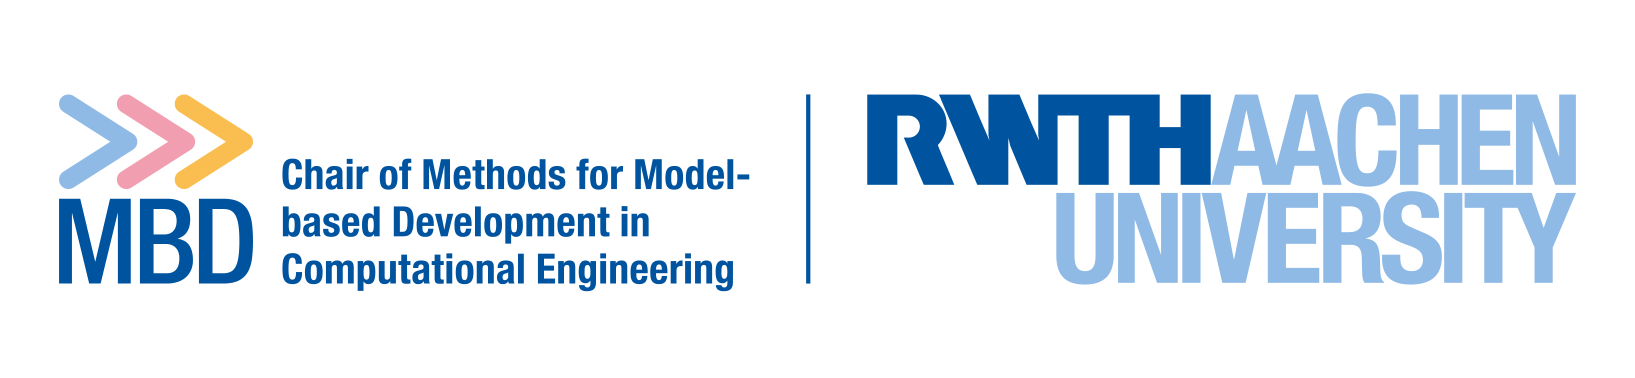
</a>
<a href="https://www.cpbl.rwth-aachen.de/">
    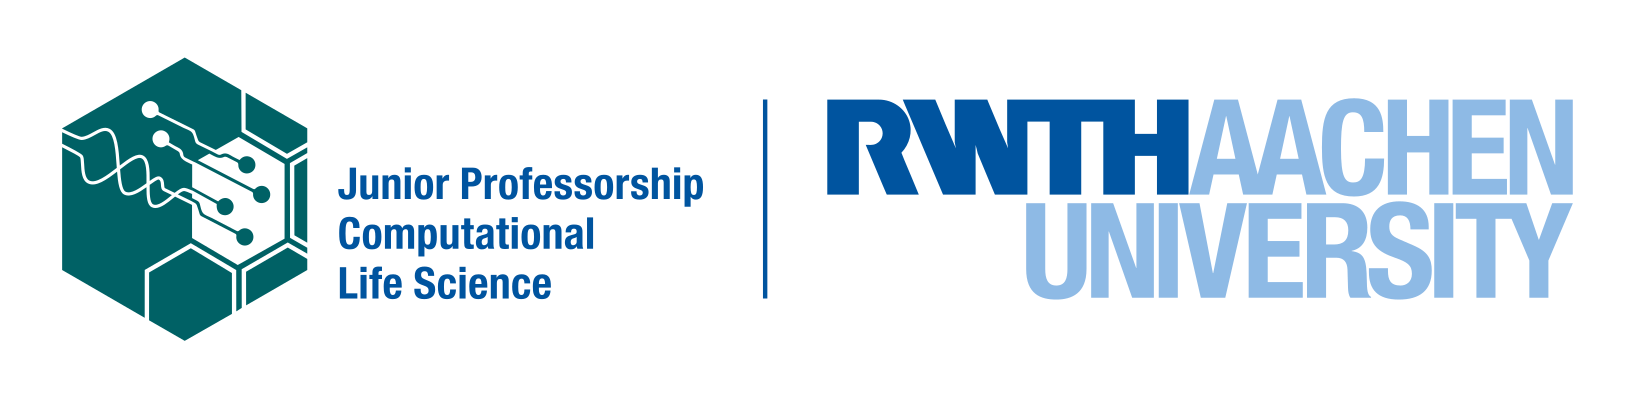
</a>

# Lecture 4

**21 January 2026**

- Dr. Marvin van Aalst (marvin.van.aalst@rwth-aachen.de)
- Nazanin Bagherinejad (bagherinejad@mbd.rwth-aachen.de)

**Credit**
  
This lecture is based on original work by Ann-Kathrin Edrich, Anna Simson and Nazanin Bagherinejad



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy import stats
from sklearn import datasets
from sklearn.datasets import (
    load_diabetes,
    load_iris,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingRegressor,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingRegressor,
    VotingClassifier,
)
from sklearn.linear_model import LassoCV, LogisticRegression, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

rng = np.random.default_rng(seed=42)

## Interpretable models

- SHAP (SHapley Additive exPlanation) leverages the idea of Shapley values for model feature influence scoring. [Shapely values](https://christophm.github.io/interpretable-ml-book/shapley.html) are the average marginal contribution of a feature value over all possible coalitions
- [LIME](https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html) (Local Interpretable Model-agnostic Explanations) builds sparse linear models around each prediction to explain how the black box model works in that local vicinity

LIME cannot provide the guarantee of accuracy and consistency of SHAP, but in practice, SHAP is too slow to work on larger datasets.  
So usually LIME is used.   

In [ ]:
# Create two distributions
d1 = stats.norm(loc=-1.0, scale=1.0)
d2 = stats.norm(loc=1.0, scale=1.0)

# Create features and target from those distributions
# rvs = Generate random variables
features = np.append(d1.rvs(size=20), d2.rvs(size=20)).reshape(-1, 1)
target = np.append(np.zeros(20), np.ones(20))
features_test = np.append(d1.rvs(size=20), d2.rvs(size=20)).reshape(-1, 1)
target_test = np.append(np.zeros(20), np.ones(20))

model = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    random_state=42,
    max_iter=500,
    class_weight="balanced",
)
model.fit(features, target)

In [ ]:
explainer = LimeTabularExplainer(
    features,
    feature_names=["a", "b"],
    verbose=True,
    mode="regression",
)

explainer.explain_instance(
    features[0],
    model.predict,
).show_in_notebook()


explainer.explain_instance(
    features[6],
    model.predict,
).show_in_notebook()

In [ ]:
explainer = shap.LinearExplainer(model, features)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features)

## Model ensembles

Ensemble methods **combine the predictions of several base estimators** built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

### Ensembles using multiple model types

- [Stacking](https://scikit-learn.org/stable/modules/ensemble.html#stacking)
- [Voting](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

### Stacking

Stacked generalization is a method for combining estimators to reduce their biases. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.

In [ ]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [ ]:
print(
    f"R2 score (RidgeCV): {r2_score(y_test, RidgeCV().fit(X_train, y_train).predict(X_test)):.2f}"
)
print(
    f"R2 score (LassoCV): {r2_score(y_test, LassoCV(random_state=42).fit(X_train, y_train).predict(X_test)):.2f}"
)
print(
    f"R2 score (KNN): {r2_score(y_test, KNeighborsRegressor(n_neighbors=20, metric='euclidean').fit(X_train, y_train).predict(X_test)):.2f}"
)

In [ ]:
estimators = [
    ("ridge", RidgeCV()),
    ("lasso", LassoCV(random_state=42)),
    ("knr", KNeighborsRegressor(n_neighbors=20, metric="euclidean")),
]
final_estimator = GradientBoostingRegressor(
    n_estimators=25,
    subsample=0.5,
    min_samples_leaf=25,
    max_features=1,
    random_state=42,
)
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
)


print(f"R2 score: {r2_score(y_test, reg.fit(X_train, y_train).predict(X_test)):.2f}")

### Voting

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote (**hard vote**) or the average predicted probabilities (**soft vote**) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [ ]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("gnb", clf3)],
    voting="hard",
)

for clf, label in zip(
    [clf1, clf2, clf3, eclf],
    ["Logistic Regression", "Random Forest", "naive Bayes", "Ensemble"],
    strict=True,
):
    scores = cross_val_score(clf, X, y, scoring="accuracy", cv=5)
    print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std():0.2f}) [{label}]")

In [ ]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("gnb", clf3)],
    voting="soft",
)

for clf, label in zip(
    [clf1, clf2, clf3, eclf],
    ["Logistic Regression", "Random Forest", "naive Bayes", "Ensemble"],
    strict=True,
):
    scores = cross_val_score(clf, X, y, scoring="accuracy", cv=5)
    print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std():0.2f}) [{label}]")

### Ensembles using one model type

- [Gradient-boosted trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees). `HistGradientBoostingClassifier` can be orders of magnitude faster than `GradientBoostingClassifier`
- [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) fits a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.
- [RandomForestClassifiers](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles) are a perturb-and-combine technique, which means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

In [ ]:
X, y = load_iris(return_X_y=True)

clf = HistGradientBoostingClassifier(max_iter=100).fit(X, y)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

In [ ]:
X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

In [ ]:
X, y = load_iris(return_X_y=True)
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

# Your feedback - student evaluation

https://evasys.rwth-aachen.de/evasys/online.php?pswd=CP7Q4 

<image src="assets/survey.png">